Description: This is a mock take-home challenge from a pretend company called "Relax, Inc." We're given two .csv files, one which contains records about each signed-up user and one which is a log of individual signins. 

Objective: The challenge is to identify which factors predict future user adoption, where an "adopted user" is defined as a user who has logged into the product on three separate days in at least one seven­day period

Deliverables: A code notebook and a brief writeup

In [1]:
#import basic libaries for data wrangling and eda  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [2]:
#load the users csv to a pandas df and check it out
users = pd.read_csv('takehome_users.csv', encoding='latin1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.shape

(12000, 10)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.nunique()

object_id                     12000
creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
dtype: int64

There are 12000 unique "object_id" entries (a unique identifier for each user), but only 8823 recorded "last_session_creation_time"s. We can already see that we have some repeated user names and email addresses, which we'll need to investigate further down the road. Speaking of that creation time, the object type for that is float64 because it's actually a unix timestamp. The creation time feature is of type object. We may need to convert these to dt objects down the line, but for now I'll just take note of them.

In [6]:
#load the user engagement csv to a pandas df and check it out
usage = pd.read_csv('takehome_user_engagement.csv', encoding='latin1')
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
usage.shape

(207917, 3)

In [8]:
usage.nunique()

time_stamp    207220
user_id         8823
visited            1
dtype: int64

In [9]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [10]:
#check for duplicates -- no duplicates
usage.drop_duplicates(inplace=True)
usage.shape

(207917, 3)

We have timestamp data for 207,917 distinct logins from 8823 distinct users. The timestamp data is of type object and will need to be converted to datetime to do any calculations with it.

Lets go ahead and do that now.


In [11]:
import datetime as dt

usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])

usage.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3 MB


My plan of attack here is to define a function which, for each user in users, checks in usage whether that user has had 3 logins in a 7 day period, returning 1 if they are "adopted" and 0 if they are not, and adding that value into a new column "adopted" in the users df.

## Find and label adopted users

In [12]:
#define a function "active" which returns 1 if a user is adopted and 0 if they are not

def activity(id):
    df = usage[usage['user_id'] == id]
    if len(df) < 3:
        return 0
    else: 
        for i in range(len(df)-2):
            if (df['time_stamp'].iloc[i+2] - df['time_stamp'].iloc[i]).days <=7:
                return 1
        return 0

In [13]:
#create a list which holds all the users who have logged in
usage_users = list(usage['user_id'].unique())

#create an empty list to hold adopted status
adopted_status = []

#find status of each user who has logged in
for user in usage_users:
    status = activity(id=user)
    adopted_status.append(status)

#create a 3rd df that holds active status for each user
adopted_users = pd.DataFrame({'user_id' : usage_users, 'adopted' : adopted_status})

adopted_users.head()

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [14]:
print(adopted_users.adopted.value_counts())

print(adopted_users.adopted.value_counts(normalize=True))

0    7167
1    1656
Name: adopted, dtype: int64
0    0.812309
1    0.187691
Name: adopted, dtype: float64


So, of the users we have login data for, only 18.8% of them are active/adopted users.

Let's wrap up this part of the work by joining the active users table to the users df.

In [15]:
#rename 'object_id' to 'user_id' to prepare for the join
users.rename(columns = {'object_id' : 'user_id'}, inplace=True)

users = pd.merge(users, adopted_users, on='user_id', how='outer')

users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


## Preliminary cleaning

In [16]:
#time for some clean up

#convert times to dt objects
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

#fill NaN values in 'adopted' and 'invited_by_user_id' with 0
users['adopted'].fillna(0,inplace=True)
users['invited_by_user_id'].fillna(0,inplace=True)

#cast adopted column to type int
users['adopted'] = users['adopted'].astype(int)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

#cast org_id and invited_by_user_id columns to type str
#users['invited_by_user_id'] = users['invited_by_user_id'].astype(str)
users['org_id'] = users['org_id'].astype(str)

#standardize name and email fields to be all lowercase
users['name'] = users['name'].str.lower()
users['email'] = users['email'].str.lower()

#sort df so that active users are first:
#users.sort_values(['active'], inplace=True, ascending=False)



In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  object        
 9   invited_by_user_id          12000 non-null  int64         
 10  adopted                     12000 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage

In [18]:
#check duplicate records based on matching name and email address and org_id
old_users = users
duplicate_name_and_email = users.drop_duplicates(['email', 'name'], keep='first')
duplicate_name_email_and_orgid = users.drop_duplicates(['email', 'name', 'org_id'], keep='first')
print('there are {} records with same name and email address'.format(len(old_users) - len(duplicate_name_and_email)))
print('there are {} records with same name and email address and org_id'.format(len(old_users) - len(duplicate_name_email_and_orgid)))


there are 19 records with same name and email address
there are 0 records with same name and email address and org_id


So, that's interesting, there are a handful of duplicate records with the same name and email address, however when we take into account the organization id number, there are no duplicate entries. Because an association with a different organization could be a factor in a user's active status, we won't drop any of these entries.

In [19]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,clausen august,augustcclausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0
1,2,2013-11-15 03:45:04,poole matthew,matthewpoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1
2,3,2013-03-19 23:14:52,bottrill mitchell,mitchellbottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0
3,4,2013-05-21 08:09:28,clausen nicklas,nicklassclausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0
4,5,2013-01-17 10:14:20,raw grace,graceraw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0


## Feature Engineering

Time for some more feature engineering and cleanup.

    1. add feature col for year and month of account creation
    2. add feature col for the email domain
    3. add a feature column that tells whether the user was invited by an active user
    4. add organization metrics
    5. add invitation behavior

### Feature 1: extract year and month of account creation

In [20]:
#1. add a feature col for the year-month of account creation
users['creation_year_month'] = users['creation_time'].dt.strftime('%Y-%m')
users['creation_year'] = users['creation_time'].dt.strftime('%Y')
users.drop('creation_time', axis=1, inplace=True)
users.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year
0,1,clausen august,augustcclausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014
1,2,poole matthew,matthewpoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013
2,3,bottrill mitchell,mitchellbottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013
3,4,clausen nicklas,nicklassclausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013
4,5,raw grace,graceraw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013


### Feature 2: extract email domain

In [21]:
#2. add feature col for the email domain
users['email_domain'] = users['email'].str.split('@').str[1]
users.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year,email_domain
0,1,clausen august,augustcclausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014,yahoo.com
1,2,poole matthew,matthewpoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013,gustr.com
2,3,bottrill mitchell,mitchellbottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013,gustr.com
3,4,clausen nicklas,nicklassclausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013,yahoo.com
4,5,raw grace,graceraw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013,yahoo.com


In [22]:
#get a sense for which email domains are most common. 

users.email_domain.value_counts(normalize=True).nlargest(7)


gmail.com         0.296833
yahoo.com         0.203917
jourrapide.com    0.104917
cuvox.de          0.100167
gustr.com         0.098250
hotmail.com       0.097083
rerwl.com         0.000167
Name: email_domain, dtype: float64

In [23]:
#looks like there are 6 email domains that account for nearly 90% of the users, and a lot of domains with just one user
#let's categorize those oddballs as 'other' 
users['email_domain_clean'] = np.where((users['email_domain'].isin(['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com'])), users['email_domain'], 'other')

#drop email field and email_domain field
users.drop(['email','email_domain'], axis=1, inplace=True)
users.rename(columns={'email_domain_clean':'email_domain'},inplace=True)

#check for success
users.head()

,user_id,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year,email_domain
0,1,clausen august,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014,yahoo.com
1,2,poole matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013,gustr.com
2,3,bottrill mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013,gustr.com
3,4,clausen nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013,yahoo.com
4,5,raw grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013,yahoo.com


In [24]:
#check for success

users.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
other             1186
gustr.com         1179
hotmail.com       1165
Name: email_domain, dtype: int64

### Feature 3: check if user was invited by an adopted user

In [25]:
#3: add a feature col that tells whether the user was invited by an adopted user using a self join

#create df to hold just the cols we want for the self join
df = users[['user_id','adopted']] 

#create join
users2 = pd.merge(users, df, how='left', left_on='invited_by_user_id', right_on='user_id').drop(['user_id_y'], axis=1).rename(columns={'adopted_x':'adopted','adopted_y':'invited_by_adopted_user','user_id_x':'user_id'})

#fill NaN values in new feature with 0
users2['invited_by_adopted_user'].fillna(0,inplace=True)

#cast new col as type int
users2['invited_by_adopted_user'] = users2['invited_by_adopted_user'].astype(int)

users2.head()


,user_id,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year,email_domain,invited_by_adopted_user
0,1,clausen august,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014,yahoo.com,0
1,2,poole matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013,gustr.com,0
2,3,bottrill mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013,gustr.com,1
3,4,clausen nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013,yahoo.com,1
4,5,raw grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013,yahoo.com,1


### Feature set 4: add organization size, number of active users in organization, and the percentage of users from the org who are adopted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   org_id           417 non-null    object 
 1   n_org_users      417 non-null    int64  
 2   n_org_active     417 non-null    int64  
 3   org_pct_adopted  417 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 13.2+ KB


None

Text(0.5, 1.0, 'Distribution of percentages of adopted users by organization')

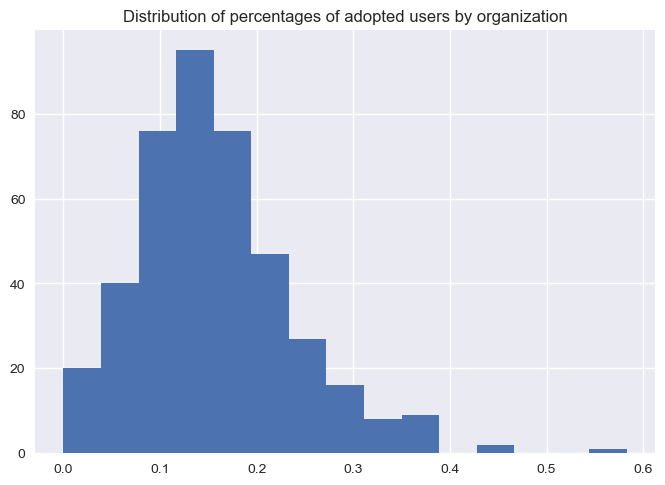

In [26]:
#4: create a count of adopted users in each organization
org_counts = users2[['org_id','adopted']].groupby('org_id').agg(n_org_users=('adopted','count'), n_org_active=('adopted','sum')).reset_index()

#add a column that find the pct adopted users in the org
org_counts['org_pct_adopted'] = org_counts['n_org_active']/org_counts['n_org_users']

display(org_counts.info())
org_counts.org_pct_adopted.hist(bins=15).set_title('Distribution of percentages of adopted users by organization')



In [27]:
#create join to add organization stats as features
users = pd.merge(users2, org_counts, how='left', on='org_id')

users.head()

,user_id,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year,email_domain,invited_by_adopted_user,n_org_users,n_org_active,org_pct_adopted
0,1,clausen august,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014,yahoo.com,0,75,8,0.106667
1,2,poole matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013,gustr.com,0,233,16,0.068670
2,3,bottrill mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013,gustr.com,1,32,7,0.218750
3,4,clausen nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013,yahoo.com,1,233,16,0.068670
4,5,raw grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013,yahoo.com,1,16,4,0.250000


### Feature 5: check to see how many users each user has invited, and whether they are active

In [28]:
#aggregate to get the number of entries invited by each user id and how many of those are adopted
invitation_counts = users.groupby('invited_by_user_id').agg(n_invited_users = ('invited_by_user_id','count'), n_users_adopted_and_invited = ('adopted','sum')).reset_index()

#add a column that find the pct adopted users in the org
invitation_counts['invitations_pct_adopted'] = invitation_counts['n_users_adopted_and_invited']/invitation_counts['n_invited_users']
display(invitation_counts)

,invited_by_user_id,n_invited_users,n_users_adopted_and_invited,invitations_pct_adopted
0,0,5583,713,0.127709
1,3,1,0,0.000000
2,7,5,0,0.000000
3,10,1,0,0.000000
4,21,1,0,0.000000
...,...,...,...,...
2560,11981,1,0,0.000000
2561,11986,1,0,0.000000
2562,11994,7,2,0.285714
2563,11997,1,0,0.000000


In [29]:
#create join to add invitation stats as features, fill na with 0
users2 = pd.merge(users, invitation_counts, how='left', left_on='user_id', right_on='invited_by_user_id').drop('invited_by_user_id_y',axis=1).rename(columns={'invited_by_user_id_x':'invited_by_user_id'}).fillna(0)

#cast to type int
users2['n_invited_users'] = users2['n_invited_users'].astype(int)
users2['n_users_adopted_and_invited'] = users2['n_users_adopted_and_invited'].astype(int)

users2.head()

,user_id,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year_month,creation_year,email_domain,invited_by_adopted_user,n_org_users,n_org_active,org_pct_adopted,n_invited_users,n_users_adopted_and_invited,invitations_pct_adopted
0,1,clausen august,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,2014-04,2014,yahoo.com,0,75,8,0.106667,0,0,0.0
1,2,poole matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,2013-11,2013,gustr.com,0,233,16,0.068670,0,0,0.0
2,3,bottrill mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,2013-03,2013,gustr.com,1,32,7,0.218750,1,0,0.0
3,4,clausen nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,2013-05,2013,yahoo.com,1,233,16,0.068670,0,0,0.0
4,5,raw grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,2013-01,2013,yahoo.com,1,16,4,0.250000,0,0,0.0


### Save final df for modeling

In [30]:
users = users2.drop(['user_id','name','last_session_creation_time','org_id','invited_by_user_id','creation_year','creation_year_month'],axis=1)

cat_features=['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','email_domain','invited_by_adopted_user','year','year_month']
num_features = ['n_org_users',	'n_org_active',	'org_pct_adopted',	'n_invited_users',	'n_users_adopted_and_invited',	'invitations_pct_adopted']
cont_num_features = ['org_pct_adopted','invitations_pct_adopted']
discrete_num_features = [['n_org_users', 'n_org_active', 'org_pct_adopted',	'n_invited_users', 'n_users_adopted_and_invited']]

## Data Preprocessing

In [31]:
#to prepare for modeling, it's time to define our feature-space, X and target variable, y

X = users.drop('adopted',axis=1)
y = users['adopted']

X = pd.get_dummies(X)


#import Standard Scaler to scale numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, stratify = y)


In [32]:
y.value_counts(normalize=True)

0    0.862
1    0.138
Name: adopted, dtype: float64

In [33]:
y_train.value_counts(normalize=True)

0    0.861979
1    0.138021
Name: adopted, dtype: float64

Now that we have our data cleaned and ready for modeling, we can begin the modeling steps.

In [34]:
#import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#import model selection libraries
from sklearn.model_selection import cross_val_score

#import scoring metrics and visualizers
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve,  confusion_matrix,  classification_report, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

#import optuna for bayesian hyper-parameter optimization
import optuna

/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [43]:
#dampen verbosity on optuna trial output (trust me)
optuna.logging.set_verbosity(optuna.logging.WARNING)


#set up optuna trial to select the best model
def objective(trial):
    #define which models we'll try
    #classifier_name = 'XGBoost'
    #define parameter space for Logistic Regression model
    #define parameter space for XGBoost

    xgb_gamma = trial.suggest_float("xgb_gamma", 0.1, 1.0)
    xgb_maxd = trial.suggest_int("xgb_maxd", 3, 12)
    xgb_lambda = trial.suggest_float("xgb_lambda", 1e-2, 1e0, log=True)
    xgb_alpha = trial.suggest_float("xgb_alpha", 0, 1.0)
    classifier_obj = XGBClassifier(gamma = xgb_gamma, max_depth=xgb_maxd, reg_alpha=xgb_alpha, reg_lambda=xgb_lambda, use_label_encoder=False, eval_metric='mlogloss')
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=5, scoring='roc_auc')
    auroc = score.mean()
    return auroc

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, n_jobs=-1)
    print(study.best_trial)

/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

FrozenTrial(number=41, values=[0.6805757282106824], datetime_start=datetime.datetime(2022, 10, 24, 19, 12, 20, 443051), datetime_complete=datetime.datetime(2022, 10, 24, 19, 12, 45, 254621), params={'xgb_gamma': 0.86694348137203, 'xgb_maxd': 3, 'xgb_lambda': 0.9710840811437139, 'xgb_alpha': 0.8996902948748439}, distributions={'xgb_gamma': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'xgb_maxd': IntDistribution(high=12, log=False, low=3, step=1), 'xgb_lambda': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'xgb_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=41, state=TrialState.COMPLETE, value=None)


In [60]:
#define best_model using the best model from the optuna study, above--an XGBoostClassifier model with average cross validation auc = 0.698
best_model = XGBClassifier(gamma = 0.9953519594271443, max_depth=3, reg_alpha=0.014652107326654923, reg_lambda=0.09835877311655178, use_label_encoder=False, eval_metric='mlogloss')

#train best_model on entire training set:
best_model.fit(X_train,y_train)
#
#get predictions
y_pred = best_model.predict_proba(X_test)
y_pred_class = best_model.predict(X_test)

In [61]:
y_pred

array([[0.8772397 , 0.12276033],
       [0.99773455, 0.00226546],
       [0.9155686 , 0.08443143],
       ...,
       [0.91077465, 0.08922536],
       [0.8135201 , 0.1864799 ],
       [0.91932833, 0.08067168]], dtype=float32)

In [62]:
print('y_pred: {}'.format(y_pred))
print('y_pred_class: {}'.format(y_pred_class))
print('y_test: {}'.format(y_test.to_numpy()))

#calculate and print KPIs
print('Final Model KPIs:')
print("AUC score: {}".format(roc_auc_score(y_test, y_pred[:,1])))
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_class)))
print("F1 score: {}".format(f1_score(y_test, y_pred_class)))
print("Precision: {}".format(precision_score(y_test, y_pred_class)))
print("Recall: {}".format(recall_score(y_test, y_pred_class)))


y_pred: [[0.8772397  0.12276033]
 [0.99773455 0.00226546]
 [0.9155686  0.08443143]
 ...
 [0.91077465 0.08922536]
 [0.8135201  0.1864799 ]
 [0.91932833 0.08067168]]
y_pred_class: [0 0 0 ... 0 0 0]
y_test: [0 0 0 ... 0 0 0]
Final Model KPIs:
AUC score: 0.628649215363027
Accuracy score: 0.86125
F1 score: 0.08264462809917356
Precision: 0.46875
Recall: 0.045317220543806644


/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/cortega/opt/anaconda3/envs/fastai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; 

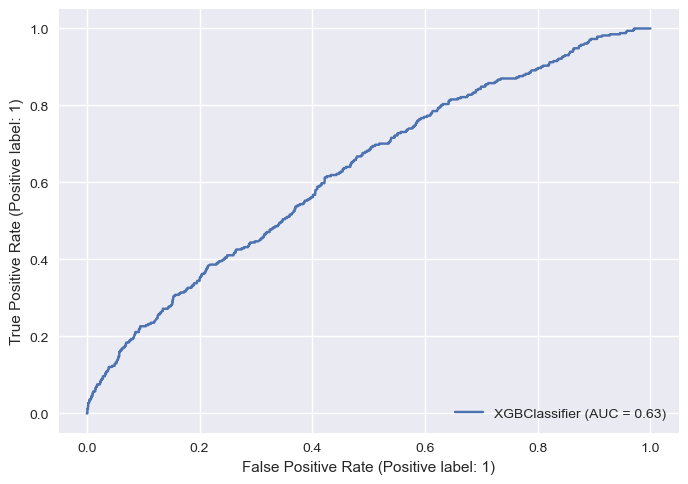

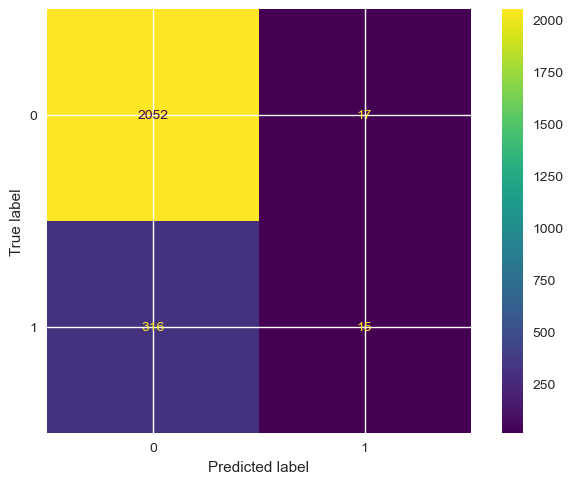

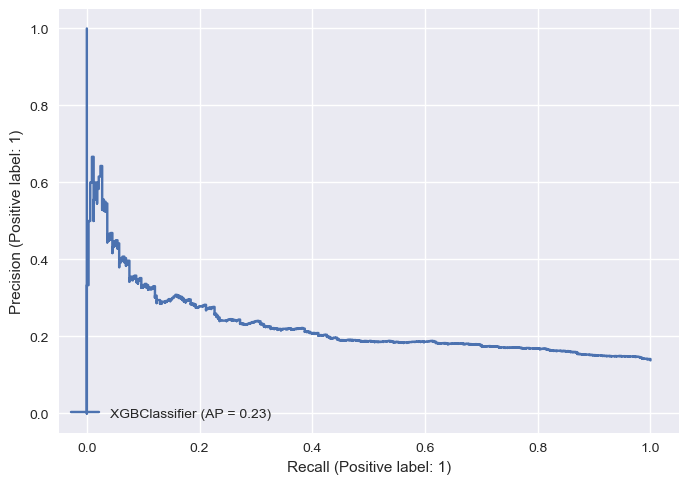

In [39]:
#roc_auc_score, plot_roc_curve, plot_precision_recall_curve,  confusion_matrix,  classification_report, accuracy_score, precision_score, recall_score, f1_score
#RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

plot_roc_curve(best_model, X_test, y_test)
plot_confusion_matrix(best_model, X_test, y_test)#, normalize='true')
plot_precision_recall_curve(best_model, X_test, y_test)

Using the default threshold of 0.5 to make predictions isn't great. I'm going to tinked with this below

Final Model KPIs:
Accuracy score: 0.6375
F1 score: 0.2701342281879195
Precision: 0.18699186991869918
Recall: 0.486404833836858
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      2069
           1       0.19      0.49      0.27       331

    accuracy                           0.64      2400
   macro avg       0.54      0.57      0.51      2400
weighted avg       0.79      0.64      0.69      2400



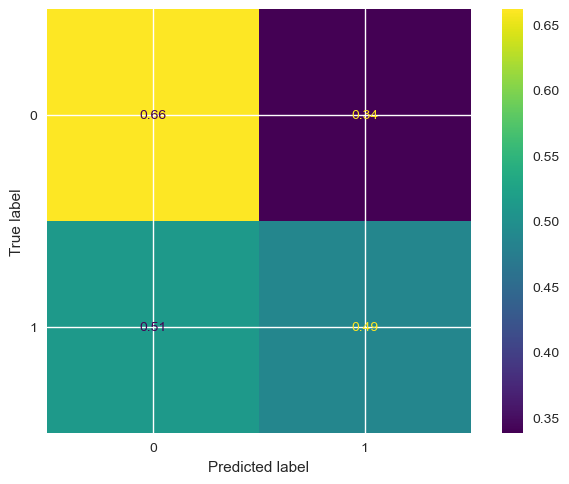

In [87]:
threshold = 0.14

y_pred_opt = np.where(pos_preds >= threshold, 1, 0)

print('Final Model KPIs:')
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_opt)))
print("F1 score: {}".format(f1_score(y_test, y_pred_opt)))
print("Precision: {}".format(precision_score(y_test, y_pred_opt)))
print("Recall: {}".format(recall_score(y_test, y_pred_opt)))

ConfusionMatrixDisplay.from_predictions(y_test,y_pred_opt, normalize='true')
print(classification_report(y_test,y_pred_opt))

Interpretation

<function matplotlib.pyplot.show(close=None, block=None)>

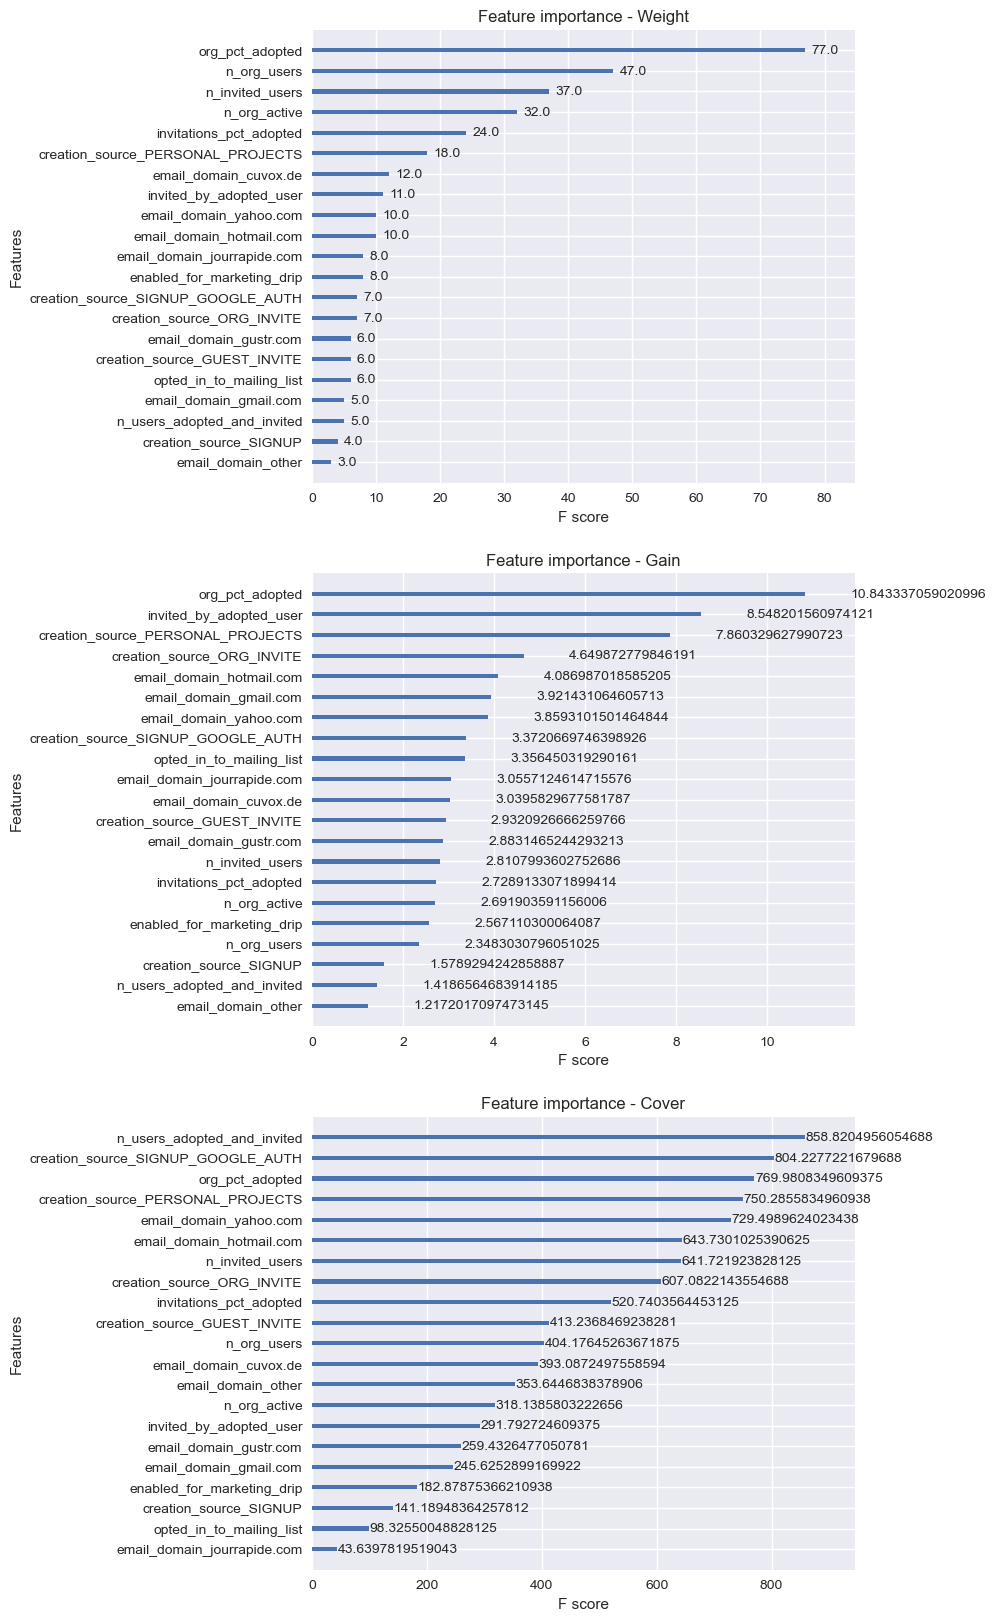

In [88]:
from operator import truediv
from xgboost import plot_importance, plot_tree

#reassign feature names to xgboost model
features = list(X.columns)
best_model.get_booster().feature_names = features

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(7,20))

#"weight" is the number of times a feature appears in a tree
plot_importance(best_model, ax=ax1, title='Feature importance - Weight', importance_type='weight')
#"gain" is the average gain of splits which use the feature
plot_importance(best_model, ax=ax2, title='Feature importance - Gain', importance_type='gain')
#"cover" is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
plot_importance(best_model, ax=ax3, title='Feature importance - Cover', importance_type='cover')
plt.show

In [41]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


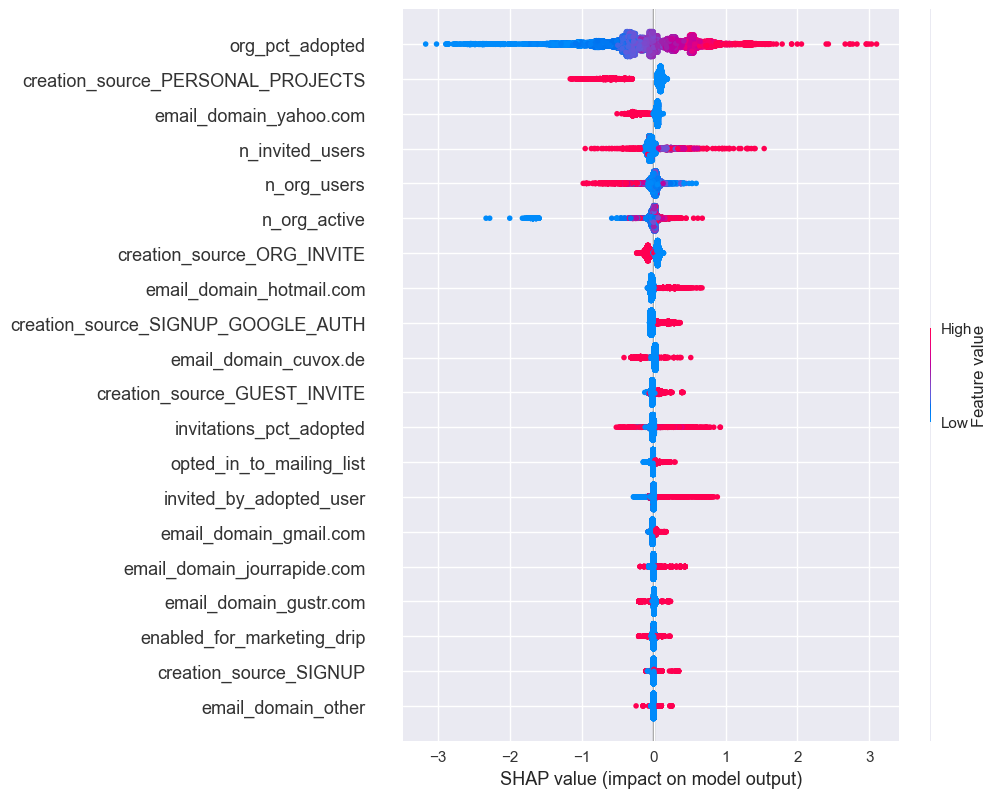

In [89]:
import shap
shap_values = shap.TreeExplainer(best_model).shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=features)